##**Fake News Detection using** **NLP**
The main objective is to develop and compare multiple models to accurately classify news as real or fake, with a focus on optimizing accuracy and F1-score.


# Project Workflow:
Text Preprocessing: Cleaning and preparing the data using tokenization, stopword removal, and lemmatization.

Feature Extraction: Converting text into numerical vectors using both CountVectorizer and TF-IDF Vectorizer.

Model Development: Implemented and evaluated three different approaches:

countVectorizer + Naive Bayes , TF-IDF + Random Forest, TF-IDF + Naive Bayes

Model Evaluation: Compared all models using accuracy, confusion matrix, and F1-score to determine the most effective approach.

#Importing all required libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Optional - Visualization
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


#Reading the data

In [2]:
df = pd.read_csv("/content/training_data_lowercase.csv",sep='\t',header = None)
df = df.rename(columns={0: 'label', 1: 'text'})

In [3]:
df.head()

,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


#Preprocessing on data



In [4]:
df["label"].value_counts() #It seems classes are balanced

,count
label,
0,17572
1,16580


Checking for nulls in the dataset

In [5]:
df.isnull().sum() # there is no null value

,0
label,0
text,0


Function for all data cleaning
             



### Text Preprocessing Pipeline Summary

This function prepares raw text data for NLP tasks like classification:

- **Tokenization**: Splits text into individual words.
- **Stopword Removal**: Removes common, less informative words like "the", "is", etc.
- **Punctuation & Number Removal**: Keeps only alphabetic characters to avoid noise.
- **Lemmatization**: Converts words to their root form (e.g., "running" → "run").

➡ This standardizes the text, reduces noise, and improves the performance of models like Naive Bayes and Random Forest by focusing on meaningful words.


In [6]:
# Download required resources
def text_preprocessing_pipeline(text):
    # Step 1: Tokenize the text
    tokens = word_tokenize(text)

    # Step 2: Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]


    # Step 3: Remove punctuation and numbers
    tokens = [re.sub(r'[^a-zA-Z]', '', word) for word in tokens]  # Keep only letters
    tokens = [word for word in tokens if word]  # Remove empty strings

    # Step 4: Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized_tokens)

In [7]:
df['clean_text'] = df['text'].apply(text_preprocessing_pipeline)


In [ ]:
df['clean_text'][0]

'washington reuters the head conservative republican faction u congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint in keeping sharp pivot way among republican u representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january when return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even november congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase nondefense discretionary spending program support education scientific research infrastructure public health environmental protection the trump administration already willing say we going increase nondefense discretionary spending percent meadow chairman small influential house freedom caucus said program now democrat saying en

In [ ]:
df['clean_text'][39937]

'the left organizing decade george soros funding from chaos occupy wall street black life matter wherever chaos anarchy america george soros democrat party usually behind there report several year voter fraud effort suggested george soros involved this another example involvement scheme effect result election america using vast global network a new campaign touted october surprise end trump seeking mobilise secret swing state million mostly unregistered global citizen progressive american living abroad vote u electionthe million american abroad almost never vote this dead easy tool fix make famous http tcozllekdub avaaz avaaz september the initiative launched london united kingdom wednesday avaaz registered u charity one world largest powerful activist group linked globalist billionaire george soros campaigner toured university college london parliament blasting bruce springsteen born usa chanting don vote trump open top buswhile illegal registered u charity work presidential candidate

In [8]:
df

,label,text,clean_text
0,0,donald trump sends out embarrassing new year‚s...,donald trump sends embarrassing new year eve m...
1,0,drunk bragging trump staffer started russian c...,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...,sheriff david clarke becomes internet joke thr...
3,0,trump is so obsessed he even has obama‚s name ...,trump obsessed even obamas name coded website ...
4,0,pope francis just called out donald trump duri...,pope francis called donald trump christmas speech
...,...,...,...
34147,1,tears in rain as thais gather for late king's ...,tear rain thai gather late king s funeral
34148,1,pyongyang university needs non-u.s. teachers a...,pyongyang university need nonus teacher travel...
34149,1,philippine president duterte to visit japan ah...,philippine president duterte visit japan ahead...
34150,1,japan's abe may have won election\tbut many do...,japan s abe may election many nt want pm


# Train Test Split

In [9]:
X = df['clean_text']
y = df['label']  # 'fake' or 'real'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape


((27321,), (6831,))

#Model 1: CountVectrorizer + NaiveBayes

###  Feature Extraction using CountVectorizer (Bag of Words)

We use `CountVectorizer` to convert our text data into numerical vectors using the Bag-of-Words approach.
- It removes English stopwords like "the", "is", etc.
- It builds a vocabulary from training data.
- It converts each text into a vector of word frequencies.

We apply `.fit_transform()` on training data (learn + convert) and `.transform()` on test data (only convert using learned vocab).


> Note: We've already removed stopwords during preprocessing using NLTK.
> Therefore, passing `stop_words='english'` to `CountVectorizer` is optional — and redundant in our case.


In [10]:
cv = CountVectorizer(stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [11]:
print("Vocabulary size:", len(cv.vocabulary_))
print("Example features:", list(cv.vocabulary_.keys())[:10])


Vocabulary size: 17392
Example features: ['final', 'reckoning', 'approach', 'obama', 'high', 'court', 'nominee', 'illinois', 'budget', 'talk']


#Basic Model Training (MultinomialNB)

we trained a basic Multinomial Naive Bayes model on CountVectorizer features. The model calculates word probabilities for each class (fake or real) and uses Bayes’ theorem to make predictions.
Note: This is your baseline model using default alpha=1.0.





In [12]:
nb1 = MultinomialNB()
nb1.fit(X_train_cv, y_train)
pred1 = nb1.predict(X_test_cv)

print("Model 1 Accuracy:", accuracy_score(y_test, pred1))

Model 1 Accuracy: 0.9307568438003221


#Hyperparameter Tuning using GridSearchCV (MultinomialNB)

The alpha parameter in Naive Bayes controls smoothing, which avoids zero probabilities for unseen words. We used GridSearchCV to find the best alpha value from [0.01, 0.1, 0.5, 1.0, 2.0] using 5-fold cross-validation.

In [13]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]}
#grid = GridSearchCV(MultinomialNB(), param_grid=params, cv=5, scoring='accuracy')
grid = GridSearchCV(MultinomialNB(), param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train_cv, y_train)

print("Best alpha:", grid.best_params_)
print("Best accuracy:", grid.best_score_)


Best alpha: {'alpha': 0.5}
Best accuracy: 0.9304197414935185


## Final Model Evaluation (CountVectrorizer + NaiveBayes)

After finding the best alpha (0.01), defaut was 1.0 using GridSearchCV, we used the optimized Naive Bayes model (`best_estimator_`) to predict labels on the test dataset.

We then evaluated the model's performance using **accuracy**, **precision**, **recall**, and **F1-score**.

This allows us to compare the tuned model with the default model and confirm whether the hyperparameter tuning improved the performance.

In [14]:
best_nb = grid.best_estimator_
y_pred_best = best_nb.predict(X_test_cv)

📌 Default Alpha (alpha=1.0):
Accuracy: 0.9307568438003221
F1 Score: 0.9284525790349417

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      3529
           1       0.93      0.93      0.93      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831


Confusion Matrix:
 [[3289  240]
 [ 233 3069]]

📌 Best Alpha (GridSearch):
Accuracy: 0.9320743668569755
F1 Score: 0.9297608234937935

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      3529
           1       0.93      0.93      0.93      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831


Confusion Matrix:
 [[3296  233]
 [ 231 3071]]


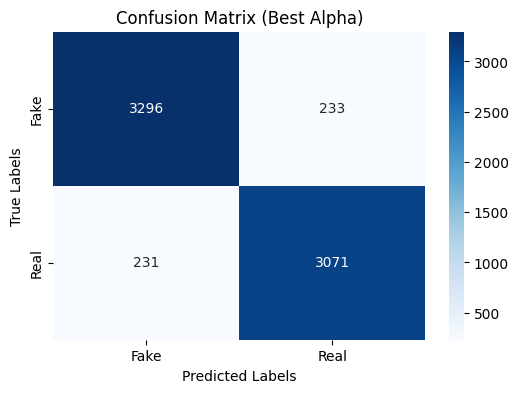

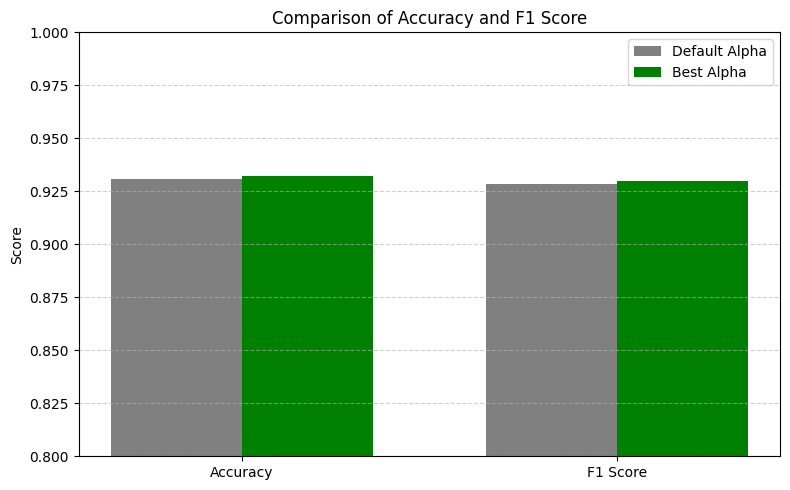

In [15]:
# Accuracy & F1 score for default alpha
acc_default = accuracy_score(y_test, pred1)
f1_default = f1_score(y_test, pred1)

# Accuracy & F1 score for best alpha
acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

# Print reports
print("📌 Default Alpha (alpha=1.0):")
print("Accuracy:", acc_default)
print("F1 Score:", f1_default)
print("\nClassification Report:\n", classification_report(y_test, pred1))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred1))

print("\n📌 Best Alpha (GridSearch):")
print("Accuracy:", acc_best)
print("F1 Score:", f1_best)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

# 🔥 Plot Confusion Matrix for Best Model
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Best Alpha)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
xtricklabels = ['Fake', 'Real']
ytricklabels = ['Fake', 'Real']
plt.xticks(np.arange(2) + 0.5, labels=xtricklabels)
plt.yticks(np.arange(2) + 0.5, labels=ytricklabels)
plt.show()

# 📊 Plot Accuracy and F1 Score Comparison
labels = ['Accuracy', 'F1 Score']
default_scores = [acc_default, f1_default]
best_scores = [acc_best, f1_best]

x = np.arange(len(labels))  # x locations
width = 0.35  # width of bars

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, default_scores, width, label='Default Alpha', color='gray')
plt.bar(x + width/2, best_scores, width, label='Best Alpha', color='green')

plt.ylabel('Score')
plt.title('Comparison of Accuracy and F1 Score')
plt.xticks(x, labels)
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



#Model2 TF-IDF +Random_forest

we convert the raw text data into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization.
    TF-IDF captures how important a word is to a document relative to the entire dataset.
    It assigns higher weights to words that appear frequently in a document but rarely across other documents, helping to highlight distinctive words.
    Using stop_words='english' removes common English words (like "the", "and") which usually do not carry much meaning.
    fit_transform is applied on the training data to learn the vocabulary and transform the text into a TF-IDF weighted matrix.
    transform is then applied on the test data using the same learned vocabulary to ensure consistency.
This numerical representation is essential because machine learning models like Random Forest cannot work directly with raw text.

Random Forest Model Accuracy: 0.9188

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3529
           1       0.91      0.92      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831



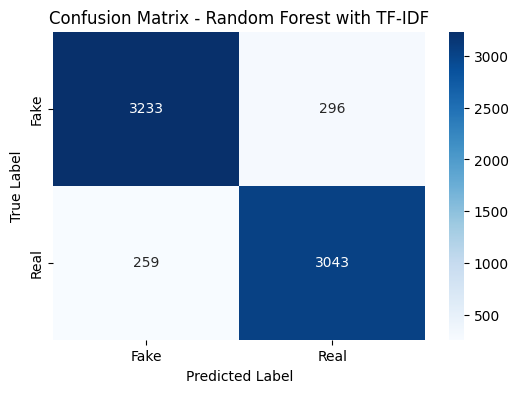

In [16]:
# Step 1: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize and train RF with default params
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_rf = rf_default.predict(X_test_tfidf)

# # Step 5: Evaluate performance
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Model Accuracy: {acc_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# # Confusion Matrix Plot
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest with TF-IDF')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(2) + 0.5, labels=['Fake', 'Real'])
plt.yticks(np.arange(2) + 0.5, labels=['Fake', 'Real'])
plt.show()


#Model_3 TFIDF +Navie Bays

In [17]:
#nb1_model_tf = nb1.fit(X_train_tfidf, y_train)
nb1_model_tf = best_nb.fit(X_train_tfidf, y_train)
pred1_tf = nb1_model_tf.predict(X_test_tfidf)
print("Model 3 Accuracy:", accuracy_score(y_test, pred1_tf))



Model 3 Accuracy: 0.930171277997365


In [18]:
confusion_matrix(y_test, pred1_tf)


array([[3302,  227],
       [ 250, 3052]])

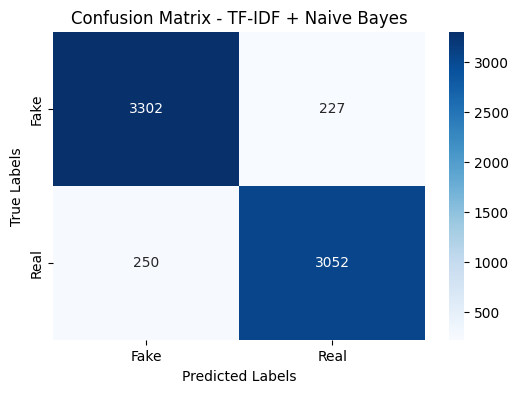

In [19]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, pred1_tf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.title('Confusion Matrix - TF-IDF + Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
xtricklabels = ['Fake', 'Real']
ytricklabels = ['Fake', 'Real']
plt.xticks(np.arange(2) + 0.5, labels=xtricklabels)
plt.yticks(np.arange(2) + 0.5, labels=ytricklabels) # Add this line to label y-axis
plt.show()


In [20]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming y_test contains integer labels (0 and 1)
# Map integer labels to string labels for classification report
target_names = ['fake', 'real']

# Generate classification reports with target_names
report1 = classification_report(y_test, pred1, target_names=target_names, output_dict=True, zero_division=0)
report2 = classification_report(y_test, y_pred_rf, target_names=target_names, output_dict=True, zero_division=0)
report3 = classification_report(y_test, pred1_tf, target_names=target_names, output_dict=True, zero_division=0)

# Extract metrics for the table
model_comparison = {
    'Model': ['CountVectorizer + Naive Bayes', 'TF-IDF + Random Forest', 'TF-IDF + Naive Bayes'],
    'Accuracy': [accuracy_score(y_test, pred1), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, pred1_tf)],
    'Fake_Precision': [report1['fake']['precision'], report2['fake']['precision'], report3['fake']['precision']],
    'Fake_Recall': [report1['fake']['recall'], report2['fake']['recall'], report3['fake']['recall']],
    'Fake_F1-score': [report1['fake']['f1-score'], report2['fake']['f1-score'], report3['fake']['f1-score']],
    'Real_Precision': [report1['real']['precision'], report2['real']['precision'], report3['real']['precision']],
    'Real_Recall': [report1['real']['recall'], report2['real']['recall'], report3['real']['recall']],
    'Real_F1-score': [report1['real']['f1-score'], report2['real']['f1-score'], report3['real']['f1-score']]
}

comparison_df = pd.DataFrame(model_comparison)
comparison_df_sorted = comparison_df.sort_values(by='Accuracy', ascending=False)
display(comparison_df_sorted)



,Model,Accuracy,Fake_Precision,Fake_Recall,Fake_F1-score,Real_Precision,Real_Recall,Real_F1-score
0,CountVectorizer + Naive Bayes,0.930757,0.933844,0.931992,0.932917,0.927471,0.929437,0.928453
2,TF-IDF + Naive Bayes,0.930171,0.929617,0.935676,0.932637,0.930772,0.924288,0.927519
1,TF-IDF + Random Forest,0.918753,0.925830,0.916124,0.920951,0.911351,0.921563,0.916428


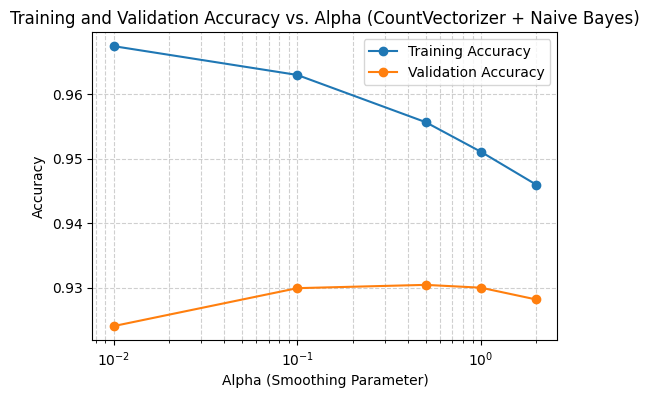

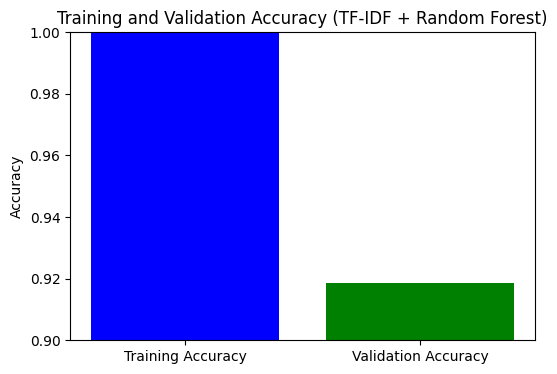

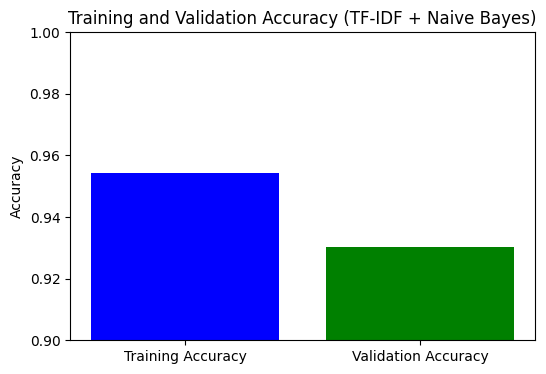

In [21]:
# For CountVectorizer + Naive Bayes
results = grid.cv_results_
train_scores = results['mean_train_score']
val_scores = results['mean_test_score']
params = results['params']

alpha_values = [p['alpha'] for p in params]

plt.figure(figsize=(6, 4))
plt.plot(alpha_values, train_scores, label='Training Accuracy', marker='o')
plt.plot(alpha_values, val_scores, label='Validation Accuracy', marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Smoothing Parameter)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Alpha (CountVectorizer + Naive Bayes)')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.show()

# For TF-IDF + Random Forest
# Calculate training accuracy
y_train_pred_rf = rf_default.predict(X_train_tfidf)
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)

# Calculate validation accuracy (already have this as acc_rf)
val_acc_rf = acc_rf

plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc_rf, val_acc_rf], color=['blue', 'green'])
plt.ylim(0.9, 1.0)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (TF-IDF + Random Forest)')
plt.show()

# For TF-IDF + Naive Bayes
# Calculate training accuracy
y_train_pred_nb_tf = nb1_model_tf.predict(X_train_tfidf)
train_acc_nb_tf = accuracy_score(y_train, y_train_pred_nb_tf)

# Calculate validation accuracy (already have this as accuracy_score(y_test, pred1_tf))
val_acc_nb_tf = accuracy_score(y_test, pred1_tf)

plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc_nb_tf, val_acc_nb_tf], color=['blue', 'green'])
plt.ylim(0.9, 1.0)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (TF-IDF + Naive Bayes)')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from IPython.display import display
# Calculate metrics for each model (Training and Validation)
positive_class_label = 1 # 1 for 'real'
# CountVectorizer + Naive Bayes (Default Alpha)
y_train_pred_cv_nb_default = nb1.predict(X_train_cv)
train_acc_cv_nb_default = accuracy_score(y_train, y_train_pred_cv_nb_default)
train_f1_cv_nb_default = f1_score(y_train, y_train_pred_cv_nb_default, pos_label=positive_class_label)

val_acc_cv_nb_default = accuracy_score(y_test, pred1)
val_f1_cv_nb_default = f1_score(y_test, pred1, pos_label=positive_class_label)

# CountVectorizer + Naive Bayes (Best Alpha)
y_train_pred_cv_nb_best = best_nb.predict(X_train_cv)
train_acc_cv_nb_best = accuracy_score(y_train, y_train_pred_cv_nb_best)
train_f1_cv_nb_best = f1_score(y_train, y_train_pred_cv_nb_best, pos_label=positive_class_label)

val_acc_cv_nb_best = accuracy_score(y_test, y_pred_best)
val_f1_cv_nb_best = f1_score(y_test, y_pred_best, pos_label=positive_class_label)

# TF-IDF + Random Forest
y_train_pred_tfidf_rf = rf_default.predict(X_train_tfidf)
train_acc_tfidf_rf = accuracy_score(y_train, y_train_pred_tfidf_rf)
train_f1_tfidf_rf = f1_score(y_train, y_train_pred_tfidf_rf, pos_label=positive_class_label)

val_acc_tfidf_rf = accuracy_score(y_test, y_pred_rf)
val_f1_tfidf_rf = f1_score(y_test, y_pred_rf, pos_label=positive_class_label)

# TF-IDF + Naive Bayes
y_train_pred_tfidf_nb = nb1_model_tf.predict(X_train_tfidf)
train_acc_tfidf_nb = accuracy_score(y_train, y_train_pred_tfidf_nb)
train_f1_tfidf_nb = f1_score(y_train, y_train_pred_tfidf_nb, pos_label=positive_class_label)

val_acc_tfidf_nb = accuracy_score(y_test, pred1_tf)
val_f1_tfidf_nb = f1_score(y_test, pred1_tf, pos_label=positive_class_label)


# Create a dictionary to hold the comparison data
model_comparison_data = {
    'Model': [
        'CountVectorizer + Naive Bayes (Default Alpha)',
        'CountVectorizer + Naive Bayes (Best Alpha)',
        'TF-IDF + Random Forest',
        'TF-IDF + Naive Bayes'
    ],
    'Training Accuracy': [
        train_acc_cv_nb_default,
        train_acc_cv_nb_best,
        train_acc_tfidf_rf,
        train_acc_tfidf_nb
    ],
    'Validation Accuracy': [
        val_acc_cv_nb_default,
        val_acc_cv_nb_best,
        val_acc_tfidf_rf,
        val_acc_tfidf_nb
    ],
     'Training F1 Score': [ # Simplified column name
        train_f1_cv_nb_default,
        train_f1_cv_nb_best,
        train_f1_tfidf_rf,
        train_f1_tfidf_nb
    ],
    'Validation F1 Score': [ # Simplified column name
        val_f1_cv_nb_default,
        val_f1_cv_nb_best,
        val_f1_tfidf_rf,
        val_f1_tfidf_nb
    ]
}

# Create the pandas DataFrame
comparison_df = pd.DataFrame(model_comparison_data)

# Sort the DataFrame by Validation Accuracy in descending order
comparison_df_sorted = comparison_df.sort_values(by='Validation Accuracy', ascending=False)

# Display the sorted table
print("Model Comparison (Training and Validation Metrics, Sorted by Validation Accuracy):")
display(comparison_df_sorted)

Model Comparison (Training and Validation Metrics, Sorted by Validation Accuracy):


,Model,Training Accuracy,Validation Accuracy,Training F1 Score,Validation F1 Score
1,CountVectorizer + Naive Bayes (Best Alpha),0.950551,0.932074,0.949197,0.929761
0,CountVectorizer + Naive Bayes (Default Alpha),0.949709,0.930757,0.948272,0.928453
3,TF-IDF + Naive Bayes,0.954357,0.930171,0.952878,0.927519
2,TF-IDF + Random Forest,1.000000,0.918753,1.000000,0.916428


In this project, we compared the performance of multiple machine learning models on a text classification task using different feature extraction methods (CountVectorizer and TF-IDF). The goal was to evaluate how well each model generalizes on unseen validation data.

##Why Random Forest with TF-IDF Underperformed

 Overfitting: Random Forest achieved perfect training performance but significantly lower validation accuracy and F1 score. This is a classic case of overfitting, where the model memorizes training data patterns—including noise—without generalizing to new data.

High Dimensionality: TF-IDF vectorization creates a large number of features (one for each unique term). This sparse and high-dimensional data is not ideal for Random Forests, which can struggle in such settings without aggressive regularization.

No Hyperparameter Tuning: Using default hyperparameters (e.g., large max_depth, many trees) adds complexity. Without tuning parameters like max_depth, min_samples_leaf, or n_estimators, the model becomes overly complex and prone to overfitting.

## Why Naive Bayes with CountVectorizer Worked Well

Simplicity and Robustness: Naive Bayes is a simple, probabilistic model that assumes independence between features. Despite the assumption being naive, it works exceptionally well in text classification tasks.

Suited for Sparse Data: It handles high-dimensional, sparse input (like that from CountVectorizer or TF-IDF) very efficiently.

Effective with Bag-of-Words: CountVectorizer captures raw word frequencies, which align well with the probabilistic foundations of Naive Bayes.

Hyperparameter Tuning: Optimizing the smoothing parameter (alpha) using GridSearchCV significantly improved performance and reduced overfitting.

#Saving Model (TF-IDF and Random Forest)

Save the trained TF-IDF vectorizer and Random Forest model to disk using pickle, and download them to y local machine for future use (e.g., in another Colab notebook).


In [23]:
import pickle
from google.colab import files

# Define filenames for your objects
cv_filename = 'cv.pkl'
model_filename = 'best_nb.pkl'

# Save the TF-IDF vectorizer
with open(cv_filename, 'wb') as file:
    pickle.dump(cv, file)

# Save the trained Random Forest model
with open(model_filename, 'wb') as file:
    pickle.dump(best_nb, file)

# Download both files
files.download(cv_filename)
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>